In [1]:
from time import time

import matplotlib.pyplot as plt

import numpy as np
from numpy.polynomial.chebyshev import chebpts1, chebvander

import jax.numpy as jnp
from jax.scipy.linalg import expm as jexpm
from jax import vmap, jacfwd, jit
from jax.lax import cond, scan, associative_scan
from jax.config import config
config.update("jax_enable_x64", True)

from qiskit_ode import dispatch, solve_lmde
from qiskit_ode.dispatch import Array
from qiskit.quantum_info import Operator
from qiskit_ode.models import HamiltonianModel, Frame
from qiskit_ode.signals import Constant, Signal
from qiskit_ode_internal.perturbation import solve_lmde_perturbation

dispatch.set_default_backend('jax')

System parameters

In [98]:
w_c = 2 * np.pi * 5.1
w_t = 2 * np.pi * 5.
alpha_c = 2 * np.pi * (-0.33)
alpha_t = 2 * np.pi * (-0.33)
J = 2 * np.pi * 0.002
# drive strength
r = 2 * np.pi * 0.05

dim = 3

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = a.transpose()
N = np.diag(np.arange(dim))
ident = np.eye(dim)
ident2 = np.eye(dim**2)

# operators on the control qubit (first tensor factor)
a0 = np.kron(a, ident)
adag0 = np.kron(adag, ident)
N0 = np.kron(N, ident)

# operators on the target qubit (first tensor factor)
a1 = np.kron(ident, a)
adag1 = np.kron(ident, adag)
N1 = np.kron(ident, N)

Hamiltonian operators.

In [99]:
H0 = (w_c * N0 + 0.5 * alpha_c * N0 @ (N0 - ident2)
      + w_t * N1 + 0.5 * alpha_t * N1 @ (N1 - ident2)
      + J * (a0 @ adag1 + adag0 @ a1))
Hdc = r*(a0 + adag0)
Hdt = r*(a1 + adag1)

In [100]:
def basis_vec(ind, dimension):
    vec = np.zeros(dimension, dtype=complex)
    vec[ind] = 1.
    return vec

def two_q_basis_vec(inda, indb, dimension):
    vec_a = basis_vec(inda, dimension)
    vec_b = basis_vec(indb, dimension)
    return np.kron(vec_a, vec_b)

def get_dressed_state_index(inda, indb, dimension, evectors):
    b_vec = two_q_basis_vec(inda, indb, dimension)
    overlaps = np.abs(evectors @ b_vec)
    return overlaps.argmax()

def get_dressed_state_and_energy(inda, indb, dimension, evecs):
    ind = get_dressed_state_index(inda, indb, dimension, evecs)
    return evals[ind], evecs[ind]

In [101]:
def gauss(t, sig):
    return jnp.exp(- (t**2) / (2 *(sig **2)))

# for jax may need ot make these conditionals
def pulse(sig, taur, tau, t):
    b = gauss(taur, sig)
    return cond(t < taur,
                lambda s: (gauss(t - taur, sig) - b) / (1 - b),
                lambda s: cond(t < tau-taur,
                               lambda r: 1.,
                               lambda r: (gauss(t - (tau - taur), sig) - b) / (1-b),
                               0.),
                0.)

Establish dressed energies and basis vectors

In [102]:
evals, B = jnp.linalg.eigh(H0)
Badj = B.conj().transpose()

E00, dressed00 = get_dressed_state_and_energy(0, 0, dim, B)
E01, dressed01 = get_dressed_state_and_energy(0, 1, dim, B)
E10, dressed10 = get_dressed_state_and_energy(1, 0, dim, B)
E11, dressed11 = get_dressed_state_and_energy(1, 1, dim, B)

In [103]:
w_d = E01
v_d = w_d / (2 * jnp.pi)
w_d - w_t

DeviceArray(-0.00025123, dtype=float64)

In [104]:
# choose parameters, express everything in terms of dt
dt = 1 / v_d

tau = 200
N = int(tau // dt)
tau = N * dt
taur = (20 //dt) * dt
sig = taur / 2

pulse_func = jnp.vectorize(lambda t: pulse(sig, taur, tau, t))

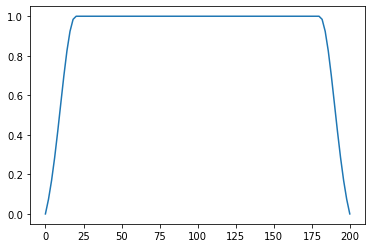

In [105]:
times = np.linspace(0, tau, 100)
vals = pulse_func(times)
plt.plot(times, vals)

In [106]:
H0_B = Badj @ H0 @ B
Hdc_B = Badj @ Hdc @ B

def full_ham(t):
    return H0_B + pulse_func(t) * jnp.cos(w_d * t) * Hdc_B

# Approximation method for signal over an interval

In [107]:
def get_DCT_data(deg, domain=[-1, 1]):
    """Construct DCT matrix for a given degree, and 
    compute the shifted chebyshev points for computing the approximation over
    domain
    """
    order = deg + 1
    xcheb = chebpts1(order)
    xcheb_shifted = 0.5*((domain[1] - domain[0]) * xcheb + (domain[1] + domain[0]))
    
    dct_mat = chebvander(xcheb, deg).T
    dct_mat[0] /= order
    dct_mat[1:] /= 0.5 * order
    
    return dct_mat, xcheb_shifted

def perform_DCT(func, dct_mat, xcheb_shifted):
    # assume vectorized
    func_vals = func(xcheb_shifted)
    return np.dot(dct_mat, func_vals)

def multi_interval_DCT(func, dct_mat, xcheb_shifted, start_point_shifts):
    dct_coeffs = [perform_DCT(func, dct_mat, xcheb_shifted + point) for point in start_point_shifts]
    return np.array(dct_coeffs)

def construct_multi_interval_DCT(deg, dt, n_intervals, start_time):
    
    # construct chebyshev data for a single interval
    dct_mat, xcheb_0 = get_DCT_data(deg, domain=[0, dt])
    
    # compute all times at which the function needs to be evaluated
    interval_start_times = start_time + np.arange(n_intervals) * dt
    # time values: columns correspond to interval, rows are the shifted chebyshev values
    t_vals = np.add.outer(xcheb_0, interval_start_times)
    
    def approx_func(func):
        f_vals = func(t_vals)
        
        return dct_mat @ f_vals

    return approx_func

In [108]:
approx_func = construct_multi_interval_DCT(1, dt, N, start_time=0)

In [109]:
vec_pulse_func = jnp.vectorize(pulse_func)

In [110]:
cheb_coeffs = approx_func(vec_pulse_func)

## Chebyshev evaluation

In [111]:
def evaluate_cheb_series(x, c, domain=[-1, 1]):
    """Evaluate a chebyshev series on a given domain.
    Aside from the domain modification this is copied from numpy,
    though I think this is a pretty classic algorithm
    """
    x = (2 * x - domain[1] - domain[0]) / (domain[1] - domain[0])

    if len(c) == 1:
        c0 = c[0]
        c1 = 0
    elif len(c) == 2:
        c0 = c[0]
        c1 = c[1]
    else:
        x2 = 2*x
        
        def scan_fun(carry, idx):
            c0, c1 = carry
            tmp = c0
            c0 = c[-idx] - c1
            c1 = tmp + c1 * x2
            return (c0, c1), None
        
        c0, c1 = scan(scan_fun, init=(c[-2], c[-1]), xs=jnp.arange(3, len(c) + 1))
        
    return c0 + c1*x

def approx_func_as_callable(cheb_coeffs, dt, n_intervals, start_time):
    interval_start_times = start_time + np.arange(n_intervals) * dt
    
    def approx_func(t):
        k = jnp.clip(jnp.array(t // dt, dtype=int), 0, cheb_coeffs.shape[-1]-1)
        return evaluate_cheb_series(t - (k * dt), cheb_coeffs[:, k], [0, dt])
    return approx_func
    

In [112]:
approx_pulse_func = approx_func_as_callable(cheb_coeffs, dt, N, 0)

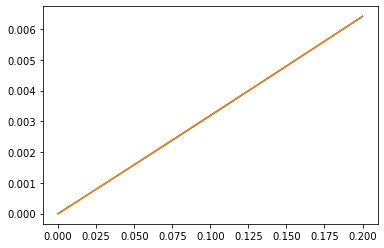

In [113]:
times = np.linspace(0, dt, 100)
vals = vec_pulse_func(times)
approx_vals = approx_pulse_func(times)
plt.plot(times, vals, times, approx_vals)

## Compute magnus approx with chebyshev polynomials

In [114]:
def G(t):
    return -1j * H0_B

def T0(t, t0):
    return evaluate_cheb_series(t - t0, [1], domain=[0, dt])

def A0(t, t0):
    return -1j * T0(t, t0) * jnp.cos(w_d * t) * Hdc_B

def T1(t, t0):
    return evaluate_cheb_series(t - t0, [0, 1], domain=[0, dt])

def A1(t, t0):
    return -1j * T1(t, t0) * jnp.cos(w_d * t) * Hdc_B

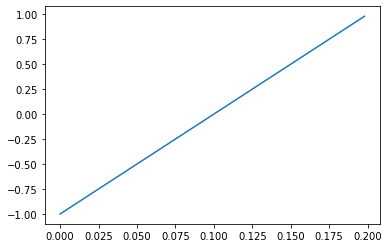

In [115]:
t_vals = jnp.arange(0, dt, dt /100)
y_vals = [T1(t, 0) for t in t_vals]
plt.plot(t_vals, y_vals)

In [116]:
start = time()
mag_results = solve_lmde_perturbation(A_list=[lambda t: A0(t, 0), lambda t: A1(t, 0)],
                                  perturbation_method='symmetric_magnus',
                                  perturbation_order=2,
                                  t_span=[0, dt],
                                  generator=G,
                                  method='jax_odeint',
                                  atol=1e-15,
                                  rtol=1e-15)
print(time() - start)

3.355644941329956


## Full simulation

In [117]:
# first simulate full Hamiltonian to as high a precision as possible for comparisons
ham = HamiltonianModel(operators=[H0_B, Hdc_B])

As a function

In [145]:
def full_sim(taur, sig):
    ham_copy = ham.copy()
    drive_func = lambda t: pulse(sig, taur, tau, t)
    ham_copy.signals = [Constant(1.), Signal(drive_func, carrier_freq=v_d)]
    ham_copy.frame = ham_copy.drift
    
    def full_ham(t):
        frame_op = jexpm(-1j * H0_B * t)
        return -1j * drive_func(t) * jnp.cos(w_d * t) * (frame_op.conj().transpose()) @ Hdc_B @ frame_op
    results = solve_lmde(full_ham, 
                     t_span=[0, N*dt],
                     y0=jnp.eye(dim**2, dtype=complex),
                     method='jax_odeint',
                    atol=1e-12,
                    rtol=1e-12)

    return results.y[-1]
    

In [146]:
jit_sim = jit(full_sim)

In [147]:
start = time()
direct_sim_y = jit_sim(taur/5, sig).block_until_ready()
print(time() - start)

14.46344780921936


## Approx simulation

In [148]:
M0 = mag_results.perturbation_results[[0]][-1]
M1 = mag_results.perturbation_results[[1]][-1]
M00 = mag_results.perturbation_results[[0, 0]][-1]
M01 = mag_results.perturbation_results[[0, 1]][-1]
M11 = mag_results.perturbation_results[[1, 1]][-1]

# single step frame operator
Uf_dt = jexpm(-1j * H0_B * dt)

# final step frame operator
Uf = jexpm(1j * H0_B * N * dt)

In [170]:
def approx_sim_full(taur, sig):
    drive_func = jnp.vectorize(lambda t: pulse(sig, taur, tau, t))
    c_coeffs = approx_func(drive_func)
    
    def approx_gen(k):
        coeffs = c_coeffs[:, k]
        c0 = coeffs[0]
        c1 = coeffs[1]
        c00 = c0 * c0
        c01 = c0 * c1
        c11 = c1 * c1
    
        return c0 * M0 -c1 * M1 + c00 * M00 - c01 * M01 + c11 * M11

    def single_step(k):
        return Uf_dt @ jexpm(approx_gen(k))

    step_propagators = vmap(single_step)(jnp.arange(0, N, dtype=int))
    #return step_propagators
    final_prop = associative_scan(jnp.matmul, step_propagators, axis=0)[-1]
    
    return Uf @ final_prop
    
    
    
jit_approx_sim_full = jit(approx_sim_full)

In [173]:
start = time()
approx_y = jit_approx_sim_full(taur/5, sig).block_until_ready()
print(time() - start)

0.03707098960876465


In [172]:
1-(jnp.abs((approx_y.conj().transpose() @ direct_sim_y).trace()) / (dim**2))**2

DeviceArray(2.14450023e-08, dtype=float64)

In [74]:
cheb_coeffs

DeviceArray([[ 0.00319804,  0.00971514,  0.01642758, ...,  0.01642758,
               0.00971514,  0.00319804],
             [ 0.00321007,  0.00330714,  0.00340539, ..., -0.00340539,
              -0.00330714, -0.00321007]], dtype=float64)

In [31]:
0.00379943

0.00379943

In [174]:
jnp.linalg.norm(direct_sim_y.conj().transpose() @ direct_sim_y - jnp.eye(dim**2))

DeviceArray(2.6810777e-11, dtype=float64)

In [175]:
jnp.linalg.norm(approx_y.conj().transpose() @ approx_y - jnp.eye(dim**2))

DeviceArray(4.70939308e-12, dtype=float64)

In [34]:
associative_scan(jnp.matmul, jnp.array([[[0., 1.], [1., 0.]], [[1., 0.], [0., -1.]], [[0., 1.], [1., 1.]]]))

DeviceArray([[[ 0.,  1.],
              [ 1.,  0.]],

             [[ 0., -1.],
              [ 1.,  0.]],

             [[-1., -1.],
              [ 0.,  1.]]], dtype=float64)